Chaining: Lens Light To Mass
============================

In this script, we chain two searches to fit `Imaging` with a strong lens model where:

 - The lens galaxy's light is a bulge+disk `EllSersic` and `EllExponential`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

The two searches break down as follows:

 1) Model the lens galaxy's light using an `EllSersic` bulge and `EllExponential` disk. The source is
 present in the image, but modeling it is omitted.
      
 2) Models the lens galaxy's mass using an `EllIsothermal` and source galaxy's light using
an `EllSersic`. The lens light model is fixed to the result of search 1.

__Why Chain?__

For many strong lenses the lens galaxy's light is distinct from the source galaxy's light, and it is therefore a valid
approach to first subtract the lens's light and then focus on fitting the lens mass model and source's light. This
provides the following benefits:

 - The non-linear parameter space defined by a bulge+disk (N=11), mass (N=5) and parametric source (N=7) models above
 has N=27 dimensions. By splitting the model-fit into two searches, we fit parameter spaces of dimensions N=11
 (bulge+disk) and N=12 (mass+source). These are more efficient to sample and less like to infer a local maxima or
 unphysical solution.

 - The lens galaxy's light traces its mass, so we can use the lens light model inferred in search 1 to initialize
 sampling of the mass model`s centre. In principle we could do this for other parameters like its `elliptical_comp``s.
 However, the lens light does not perfectly trace its mass, so in this example we omit such an approach.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

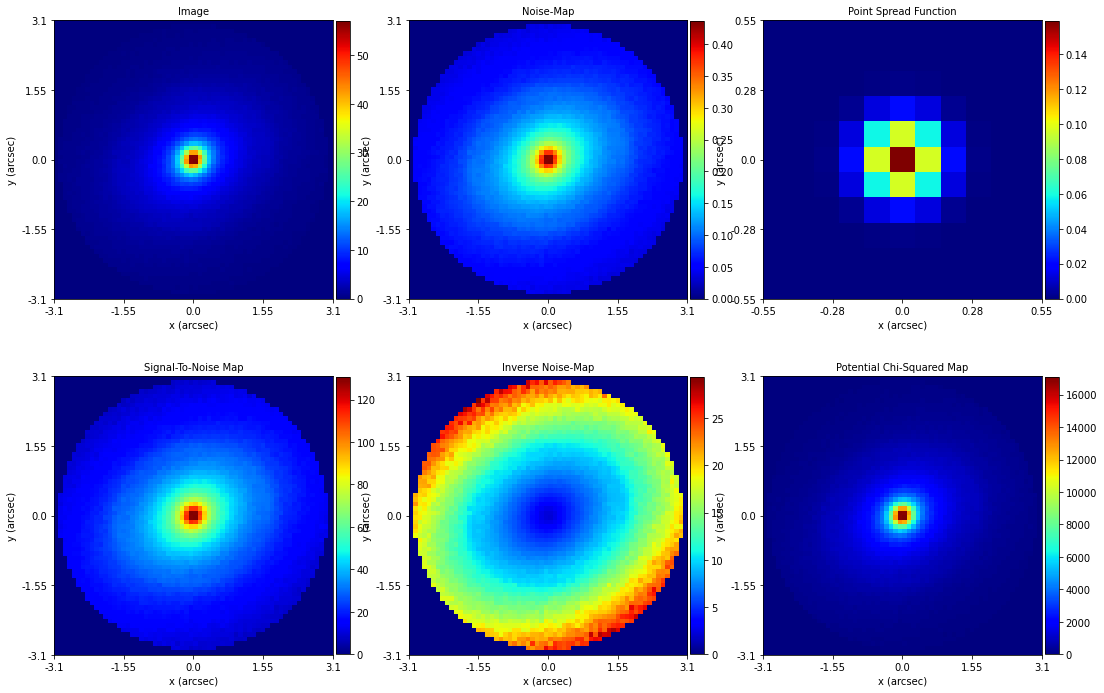

In [2]:
dataset_name = "light_sersic_exp__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "chaining", "lens_light_to_total_mass")

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's light is a parametric `EllSersic` bulge and `EllExponential` disk, the centres of 
 which are aligned [11 parameters].
 - The lens galaxy's mass and source galaxy are omitted.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=11.

In [4]:
bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllExponential)

bulge.centre = disk.centre

lens = af.Model(al.Galaxy, redshift=0.5, bulge=bulge, disk=disk)

model = af.Collection(galaxies=af.Collection(lens=lens))

__Search + Analysis + Model-Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [5]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]__lens_light", n_live_points=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 11.15it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -627077.018 <    inf | logz: -627081.682 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's light is an `EllSersic` bulge and `EllExponential` disk [Parameters fixed to results 
 of search 1].
 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

The lens galaxy's light is passed as a `instance` (as opposed to the `model` which was used in the API tutorial). By 
passing the lens light as an `instance` it passes the maximum log likelihood parameters inferred by search 1 as fixed 
values that are not free parameters fitted for by the non-linear search of search 2.

We also use the inferred centre of the lens light model in search 1 to initialize the priors on the lens mass model 
in search 2. This uses the term `model` to pass priors, as we saw in other examples.

In [6]:
mass = af.Model(al.mp.EllIsothermal)

mass.centre = result_1.model.galaxies.lens.bulge.centre

lens = af.Model(
    al.Galaxy,
    redshift=0.5,
    bulge=result_1.instance.galaxies.lens.bulge,
    disk=result_1.instance.galaxies.lens.disk,
    mass=mass,
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens))

__Search + Analysis + Model-Fit (Search 2)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the `model.info` file of the search 2 model-fit to ensure the priors were passed correctly, as 
well as the checkout the results to ensure an accurate power-law mass model is inferred.

In [7]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[2]__total_mass", n_live_points=75
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 230.03it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf < -627077.018 <    inf | logz: -627080.970 +/-    nan | dlogz:  0.511 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Wrap Up__

In this example, we passed a bulge + disk model of the lens galaxy's light as an `instance`, as opposed to a `model`, 
meaning its parameters were fixed to the maximum log likelihood model in search 1 and not fitted as free parameters in 
search 2.

Of course, one could easily edit this script to fit the bulge + disk as a model in search 2, where the results of 
search 1 initialize their priors:

 lens = af.Model(
    al.Galaxy, 
     redshift=0.5,
     bulge=result_1.model.galaxies.lens.bulge,
     disk=result_1.model.galaxies.lens.disk,
     mass=mass,
 )

As discussed in the introduction, the benefit of passing the lens's light as an instance is that it reduces the 
dimensionality of the non-linear parameter space in search 2. 

On the other hand, the lens light model inferred in search 1 may not be perfect. The source's light will impact the
quality of the fit which may lead to a sub-optimal fit. Thus, it may be better to pass the lens's light as a `model`
in search 2. The model-fit will take longer to perform, but we'll still benefit from prior passing initializing the
samples of search 2!

At the end of the day, it really comes down to you science case and the nature of your data whether you should pass the
lens light as an `instance` or `model`!

__Pipelines__

Advanced search chaining uses `pipelines` that chain together multiple searches to perform complex lens modeling 
in a robust and efficient way. 

The following example pipelines exploit our ability to model separately the lens's light and its mass / the source to 
perform model-fits in non-linear parameter spaces of reduced complexity, as shown in this example:

 `autolens_workspace/imaging/chaining/pipelines/with_lens_light/light_parametric__mass_total__source_parametric.py`
 
__SLaM (Source, Light and Mass)__
 
An even more advanced approach which uses search chaining are the SLaM pipelines, which break the lens modeling 
processing into a series of fits that first perfect the source model, then the lens light model and finally the lens
mass model. 

The SLaM pipelines begin by fitting the lens's light using a bulge+disk, and then fit the mass model and source as 
performed in this example.